📂 Loading data...
✅ Data loaded: 6812 samples, 10 features
✅ Target distribution (encoded):
0    2200
1    1419
2    1651
3    1063
4     479
Name: count, dtype: int64


=============== XGBoost ===============
🎯 Validation Accuracy: 0.7858

📊 Classification Report:
               precision    recall  f1-score   support

None_Existent      0.876     0.884     0.880       440
          Low      0.654     0.680     0.667       284
       Medium      0.777     0.748     0.762       330
         High      0.761     0.793     0.777       213
    Very_High      0.869     0.760     0.811        96

     accuracy                          0.786      1363
    macro avg      0.787     0.773     0.779      1363
 weighted avg      0.787     0.786     0.786      1363



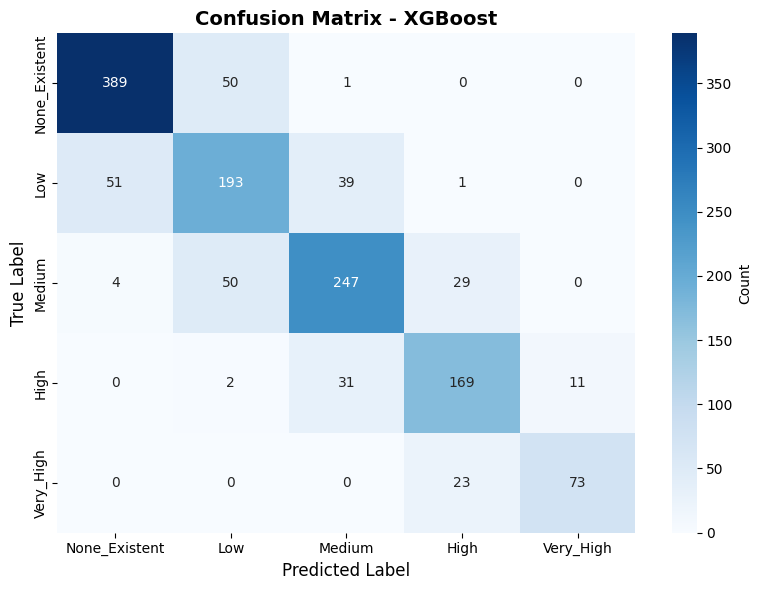

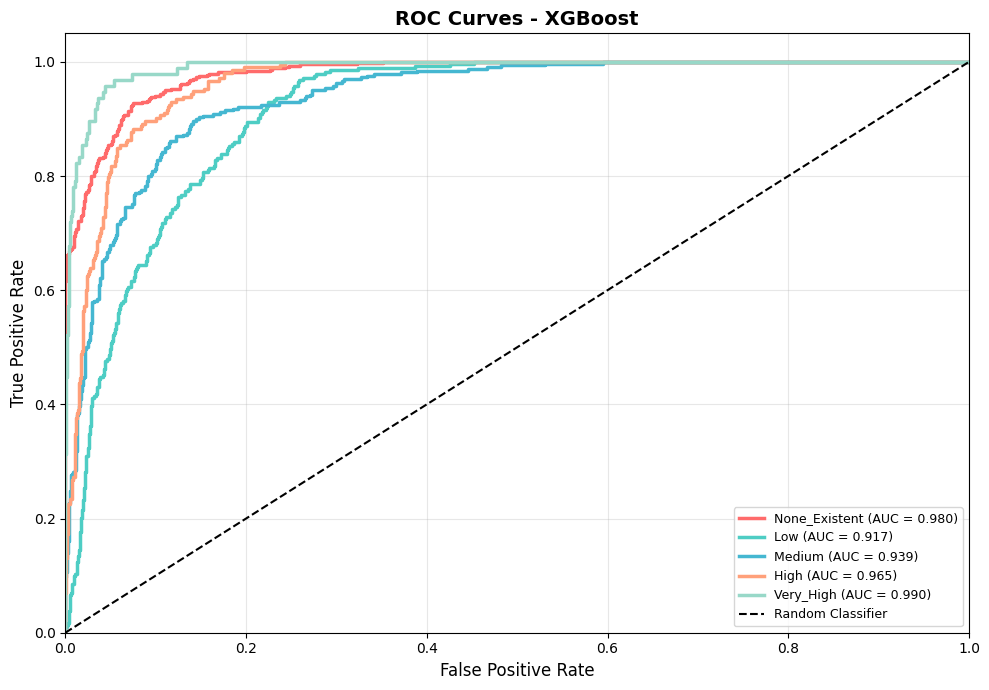

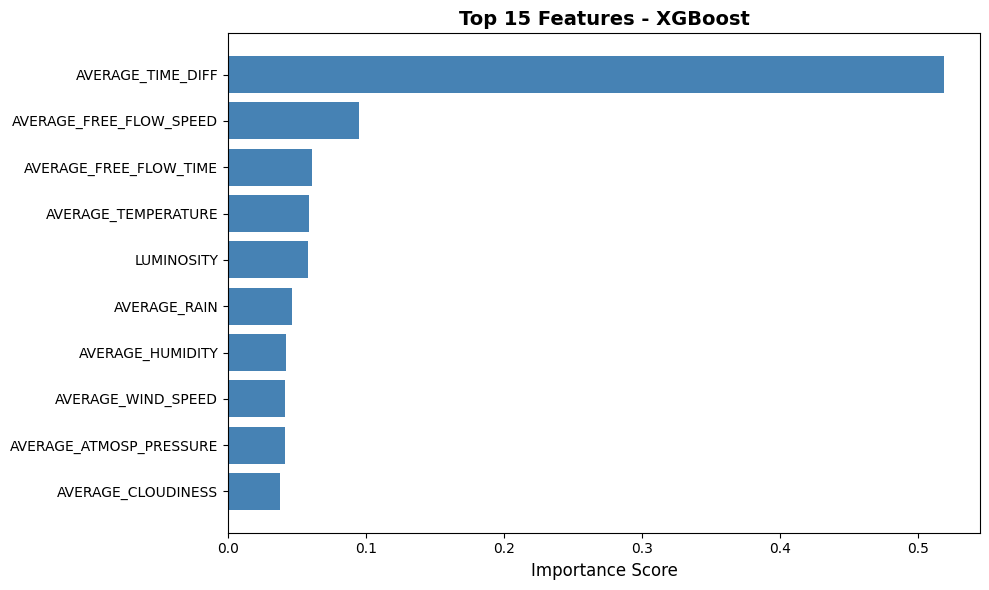


=============== RandomForest ===============
🎯 Validation Accuracy: 0.8026

📊 Classification Report:
               precision    recall  f1-score   support

None_Existent      0.885     0.911     0.898       440
          Low      0.684     0.694     0.689       284
       Medium      0.781     0.779     0.780       330
         High      0.791     0.784     0.788       213
    Very_High      0.878     0.750     0.809        96

     accuracy                          0.803      1363
    macro avg      0.804     0.784     0.793      1363
 weighted avg      0.803     0.803     0.802      1363



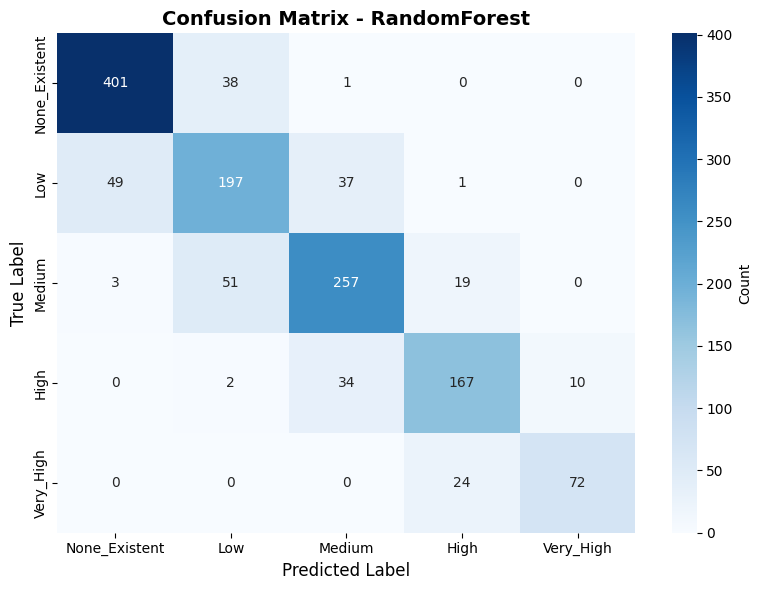

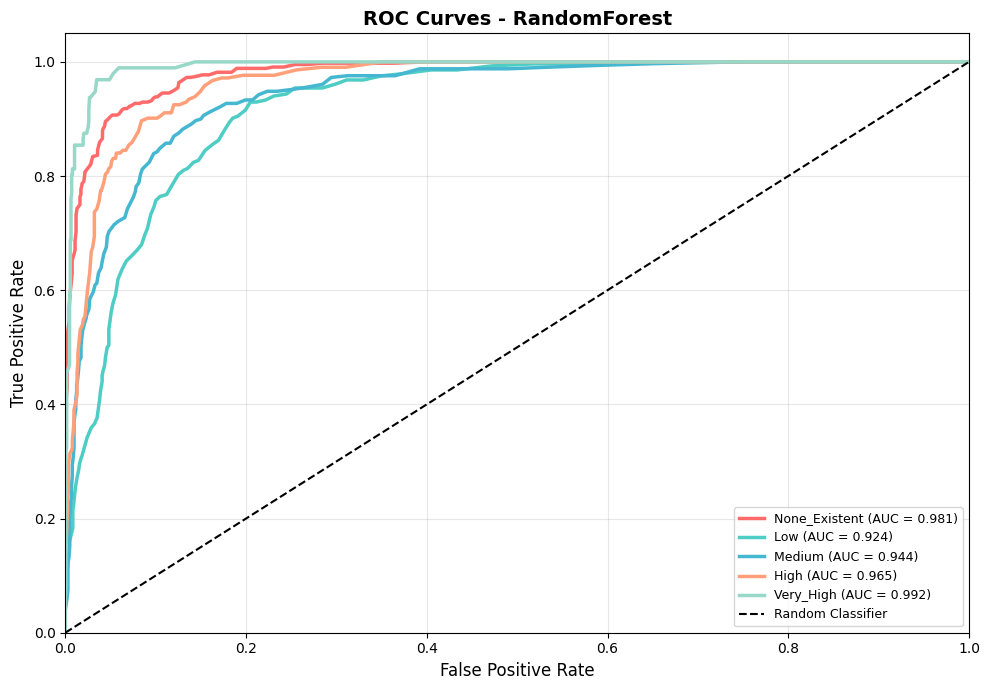

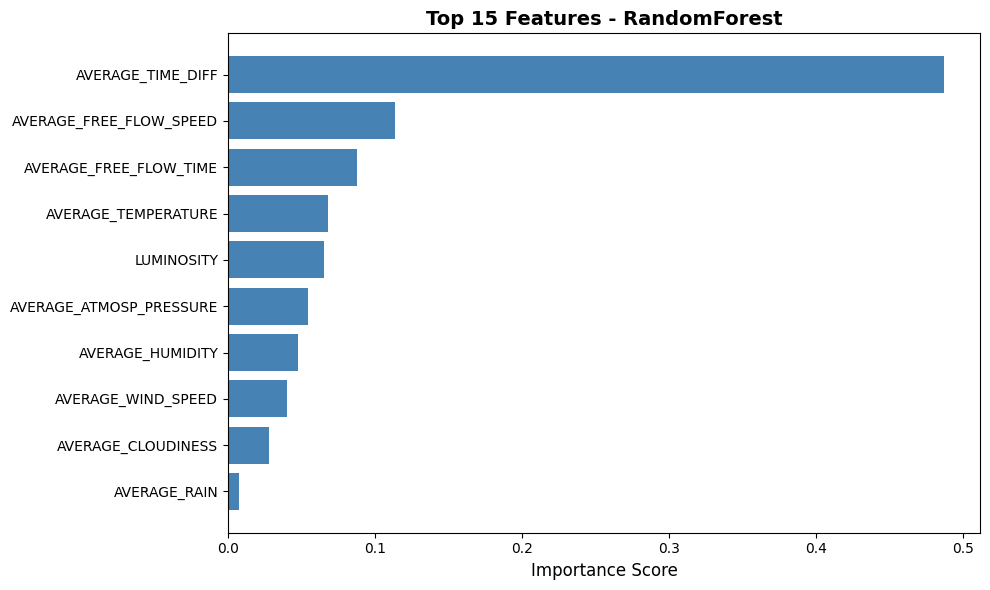


=============== LogisticRegression ===============


/home/toplapuser/.conda/envs/MECD/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/toplapuser/.conda/envs/MECD/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 2000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=2000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


🎯 Validation Accuracy: 0.7682

📊 Classification Report:
               precision    recall  f1-score   support

None_Existent      0.848     0.916     0.881       440
          Low      0.650     0.648     0.649       284
       Medium      0.767     0.739     0.753       330
         High      0.751     0.709     0.729       213
    Very_High      0.756     0.677     0.714        96

     accuracy                          0.768      1363
    macro avg      0.755     0.738     0.745      1363
 weighted avg      0.766     0.768     0.766      1363



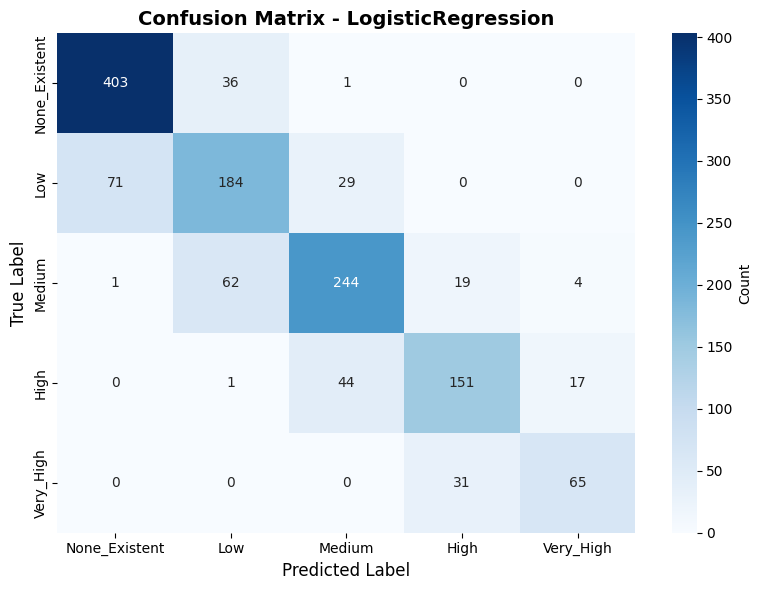

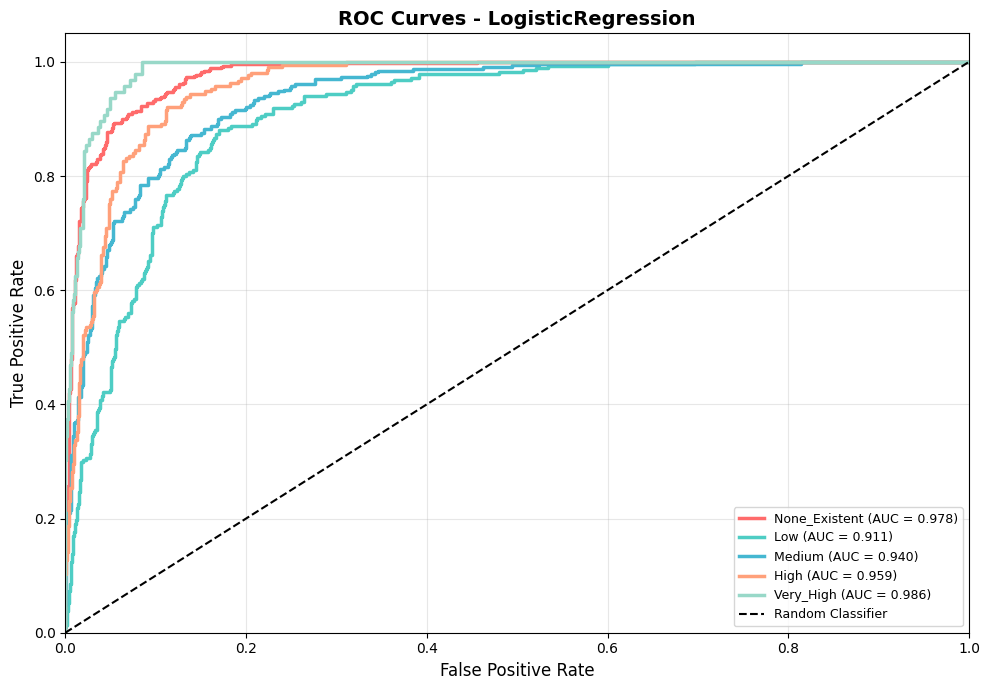


=============== Cross-Validation Scores ===============
XGBoost              | Mean: 0.7782 ± 0.0153
RandomForest         | Mean: 0.7848 ± 0.0106


/home/toplapuser/.conda/envs/MECD/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/toplapuser/.conda/envs/MECD/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/toplapuser/.conda/envs/MECD/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/toplapuser/.conda/envs/MECD/lib/python3.11/site-packages/sklearn/linea

LogisticRegression   | Mean: 0.7635 ± 0.0135

🏆 Best model: RandomForest (Accuracy: 0.8026)
🔄 Retraining RandomForest on full dataset for submission...

✅ Submission saved as "submission_organized.csv"
📈 Predicted distribution:
AVERAGE_SPEED_DIFF
None         489
Medium       344
Low          304
High         265
Very_High     98
Name: count, dtype: int64


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Models
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Metrics & Tools
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import OrdinalEncoder, label_binarize

# ============== 1. LOAD DATA ==============
print("📂 Loading data...")
X_full = pd.read_csv('data/training_data_transformed.csv')
y_full = pd.read_csv('data/y_train_transformed.csv').values.ravel()
X_test_final = pd.read_csv('data/test_data_transformed.csv')

# ============== 2. PREPROCESSING ==============
# Drop non-numeric columns
for col in X_full.columns:
    if X_full[col].dtype == 'object':
        X_full = X_full.drop(columns=[col])
        X_test_final = X_test_final.drop(columns=[col])

# y_full is already numeric (0-4), so we just ensure it's int
y_encoded = y_full.astype(int)

# Define label mapping for visualization
target_order = ['None_Existent', 'Low', 'Medium', 'High', 'Very_High']
oe = OrdinalEncoder(categories=[target_order])
oe.fit(np.array(target_order).reshape(-1, 1))

print(f"✅ Data loaded: {X_full.shape[0]} samples, {X_full.shape[1]} features")
print(f"✅ Target distribution (encoded):\n{pd.Series(y_encoded).value_counts().sort_index()}\n")

# ============== 3. TRAIN/VALIDATION SPLIT ==============
X_train, X_val, y_train, y_val = train_test_split(
    X_full, y_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded
)

# ============== 4. MODEL DEFINITIONS ==============
models = {
    'XGBoost': xgb.XGBClassifier(
        objective='multi:softprob',
        eval_metric='mlogloss',
        random_state=42,
        n_estimators=100
    ),
    'RandomForest': RandomForestClassifier(
        n_estimators=100,
        random_state=42,
        n_jobs=-1
    ),
    'LogisticRegression': LogisticRegression(
        max_iter=2000,
        random_state=42,
        multi_class='multinomial'
    )
}

# ============== 5. VISUALIZATION FUNCTIONS ==============
def plot_confusion_matrix(y_true, y_pred, model_name, labels):
    """Plot confusion matrix heatmap"""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels,
                cbar_kws={'label': 'Count'})
    plt.title(f'Confusion Matrix - {model_name}', fontsize=14, fontweight='bold')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    plt.savefig(f'confusion_matrix_{model_name}.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_roc_curves(model, X_val, y_val, model_name, labels):
    """Plot multi-class ROC curves (One-vs-Rest)"""
    n_classes = len(labels)
    y_score = model.predict_proba(X_val)
    y_val_bin = label_binarize(y_val, classes=range(n_classes))
    
    plt.figure(figsize=(10, 7))
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8']
    
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_val_bin[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2.5, color=colors[i],
                label=f'{labels[i]} (AUC = {roc_auc:.3f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=1.5, label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(f'ROC Curves - {model_name}', fontsize=14, fontweight='bold')
    plt.legend(loc="lower right", fontsize=9)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'roc_curve_{model_name}.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_feature_importance(model, feature_names, model_name, top_n=15):
    """Plot top N most important features"""
    if not hasattr(model, 'feature_importances_'):
        return
    
    importances = model.feature_importances_
    indices = np.argsort(importances)[-top_n:]
    
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(indices)), importances[indices], color='steelblue')
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.xlabel('Importance Score', fontsize=12)
    plt.title(f'Top {top_n} Features - {model_name}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'feature_importance_{model_name}.png', dpi=300, bbox_inches='tight')
    plt.show()

# ============== 6. TRAINING & EVALUATION ==============
best_score = 0
best_model_name = None

for name, model in models.items():
    print(f"\n{'='*15} {name} {'='*15}")
    
    # Train on training split
    model.fit(X_train, y_train)
    
    # Predict on validation split
    y_pred = model.predict(X_val)
    
    # Calculate accuracy
    accuracy = (y_pred == y_val).mean()
    print(f"🎯 Validation Accuracy: {accuracy:.4f}")
    
    # Track best model
    if accuracy > best_score:
        best_score = accuracy
        best_model_name = name
    
    # Classification Report
    print(f"\n📊 Classification Report:")
    print(classification_report(y_val, y_pred, target_names=target_order, digits=3))
    
    # Visualizations
    plot_confusion_matrix(y_val, y_pred, name, target_order)
    plot_roc_curves(model, X_val, y_val, name, target_order)
    plot_feature_importance(model, X_full.columns, name)

# ============== 7. CROSS-VALIDATION ==============
print(f"\n{'='*15} Cross-Validation Scores {'='*15}")
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    scores = cross_val_score(model, X_full, y_encoded, cv=cv, scoring='accuracy', n_jobs=-1)
    print(f"{name:20s} | Mean: {scores.mean():.4f} ± {scores.std():.4f}")

# ============== 8. FINAL SUBMISSION ==============
print(f"\n🏆 Best model: {best_model_name} (Accuracy: {best_score:.4f})")
print(f"🔄 Retraining {best_model_name} on full dataset for submission...")

# Retrain best model on ALL data
final_model = models[best_model_name]
final_model.fit(X_full, y_encoded)

# Predict on test set
test_predictions = final_model.predict(X_test_final)

# Decode predictions: integers → text labels
test_labels = oe.inverse_transform(test_predictions.reshape(-1, 1)).ravel()

# Create submission file
submission = pd.DataFrame({
    'RowId': np.arange(1, len(test_labels) + 1),
    'AVERAGE_SPEED_DIFF': pd.Series(test_labels).replace('None_Existent', 'None')
})

submission.to_csv('submission_organized.csv', index=False)
print('\n✅ Submission saved as "submission_organized.csv"')
print(f'📈 Predicted distribution:\n{submission["AVERAGE_SPEED_DIFF"].value_counts()}')


Cross‑validation with scaled features:


/home/toplapuser/.conda/envs/MECD/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [13:35:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/toplapuser/.conda/envs/MECD/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [13:35:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/toplapuser/.conda/envs/MECD/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [13:35:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/toplapuser/.conda/envs/MECD/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [13:35:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/to

XGBoost_scaled     | CV accuracy: 0.7782 ± 0.0153
RandomForest_scaled | CV accuracy: 0.7849 ± 0.0099
LogReg_scaled      | CV accuracy: 0.7610 ± 0.0110

=== XGBoost_scaled ===


/home/toplapuser/.conda/envs/MECD/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/toplapuser/.conda/envs/MECD/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/toplapuser/.conda/envs/MECD/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/toplapuser/.conda/envs/MECD/lib/python3.11/site-packages/sklearn/linea

Validation accuracy: 0.7858

Classification report:
               precision    recall  f1-score   support

None_Existent      0.876     0.884     0.880       440
          Low      0.654     0.680     0.667       284
       Medium      0.777     0.748     0.762       330
         High      0.761     0.793     0.777       213
    Very_High      0.869     0.760     0.811        96

     accuracy                          0.786      1363
    macro avg      0.787     0.773     0.779      1363
 weighted avg      0.787     0.786     0.786      1363



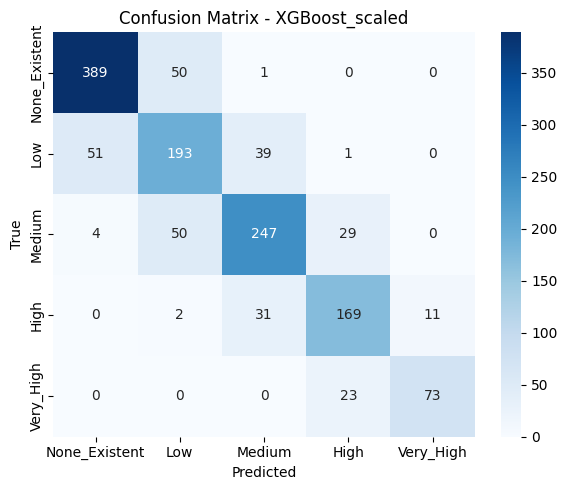

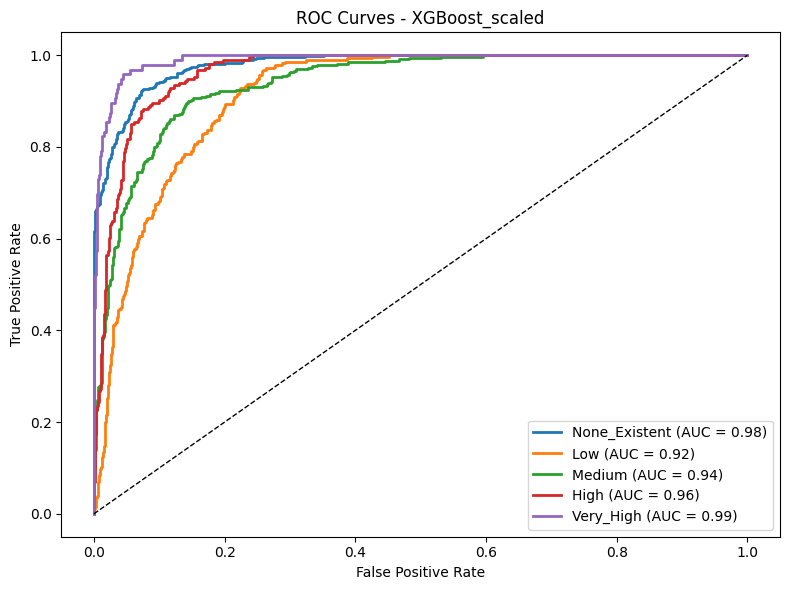


=== RandomForest_scaled ===
Validation accuracy: 0.8019

Classification report:
               precision    recall  f1-score   support

None_Existent      0.883     0.911     0.897       440
          Low      0.684     0.687     0.685       284
       Medium      0.779     0.782     0.781       330
         High      0.791     0.784     0.788       213
    Very_High      0.878     0.750     0.809        96

     accuracy                          0.802      1363
    macro avg      0.803     0.783     0.792      1363
 weighted avg      0.802     0.802     0.801      1363



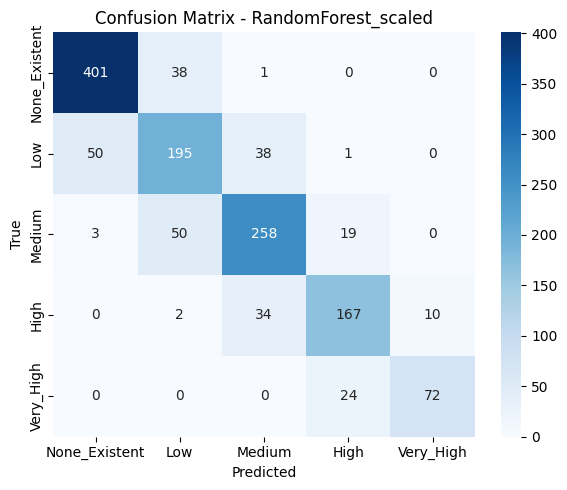

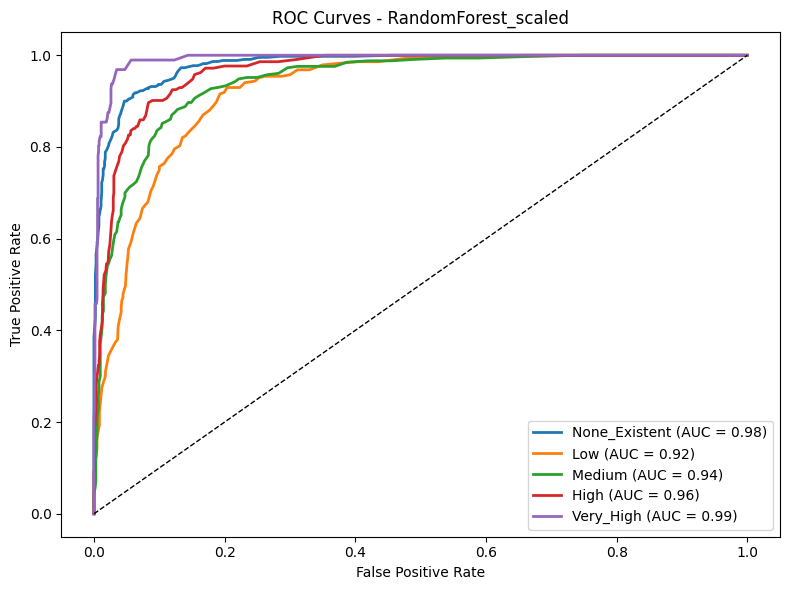


=== LogReg_scaled ===
Validation accuracy: 0.7579

Classification report:
               precision    recall  f1-score   support

None_Existent      0.812     0.934     0.869       440
          Low      0.655     0.581     0.616       284
       Medium      0.758     0.752     0.755       330
         High      0.747     0.681     0.713       213
    Very_High      0.762     0.667     0.711        96

     accuracy                          0.758      1363
    macro avg      0.747     0.723     0.733      1363
 weighted avg      0.753     0.758     0.753      1363



/home/toplapuser/.conda/envs/MECD/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


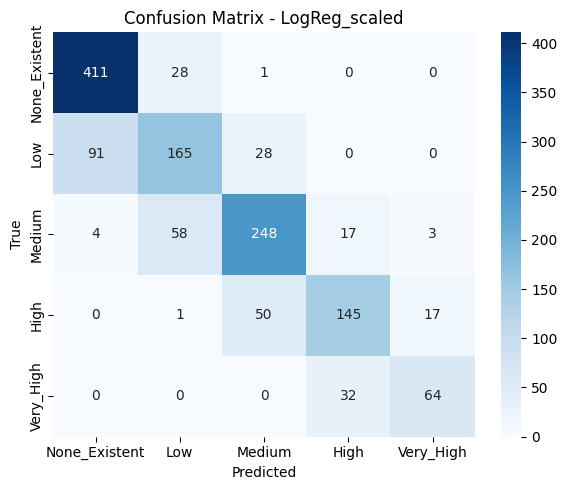

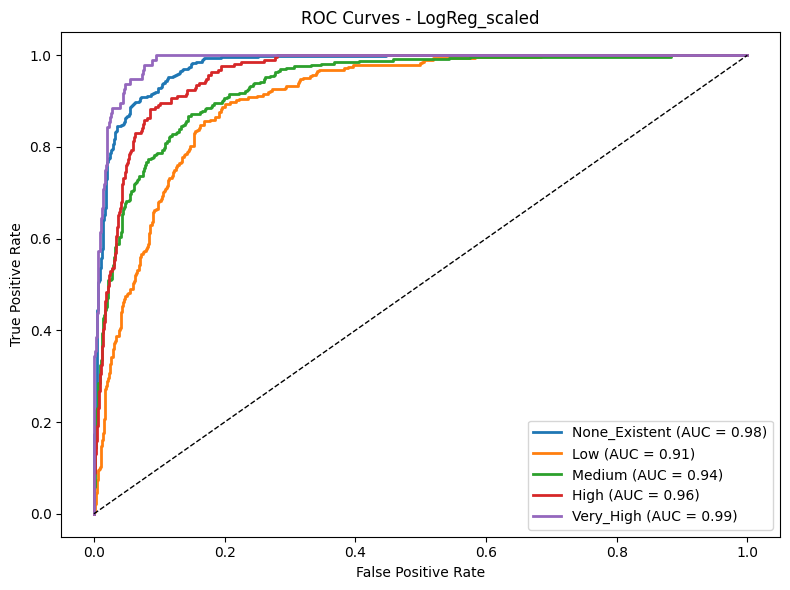


Best scaled model: RandomForest_scaled (val acc = 0.8019)
Saved submission_scaled.csv


In [6]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, label_binarize
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
import seaborn as sns

# ========= 1. LOAD DATA (same as your working code) =========
X = pd.read_csv('data/training_data_transformed.csv')
y = pd.read_csv('data/y_train_transformed.csv').values.ravel()
X_test = pd.read_csv('data/test_data_transformed.csv')

# Drop non-numeric columns
for col in X.columns:
    if X[col].dtype == 'object':
        X = X.drop(columns=[col])
        X_test = X_test.drop(columns=[col])

# y is already numeric 0–4, just ensure int
y = y.astype(int)

target_order = ['None_Existent', 'Low', 'Medium', 'High', 'Very_High']
oe_target = OrdinalEncoder(categories=[target_order])
oe_target.fit(np.array(target_order).reshape(-1, 1))

# ========= 2. DEFINE MODELS WITH SCALING PIPELINES =========
# Tree models don’t need scaling, but scaling doesn’t hurt much either
pipelines = {
    'XGBoost_scaled': Pipeline([
        ('scaler', StandardScaler()),
        ('clf', xgb.XGBClassifier(
            objective='multi:softprob',
            eval_metric='mlogloss',
            random_state=42,
            use_label_encoder=False
        ))
    ]),
    'RandomForest_scaled': Pipeline([
        ('scaler', StandardScaler()),
        ('clf', RandomForestClassifier(random_state=42))
    ]),
    'LogReg_scaled': Pipeline([
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression(
            max_iter=2000,
            random_state=42,
            multi_class='multinomial'
        ))
    ])
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("Cross‑validation with scaled features:")
for name, pipe in pipelines.items():
    scores = cross_val_score(pipe, X, y, cv=cv, scoring='accuracy', n_jobs=-1)
    print(f"{name:18s} | CV accuracy: {scores.mean():.4f} ± {scores.std():.4f}")

# ========= 3. HOLD‑OUT EVALUATION + METRICS/GRAPHS =========
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=target_order, yticklabels=target_order)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

def plot_roc_curves(pipe, X_val, y_val, model_name):
    n_classes = len(target_order)
    y_score = pipe.predict_proba(X_val)
    y_val_bin = label_binarize(y_val, classes=range(n_classes))

    plt.figure(figsize=(8, 6))
    for i in range(n_classes):
        from sklearn.metrics import roc_curve, auc
        fpr, tpr, _ = roc_curve(y_val_bin[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{target_order[i]} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves - {model_name}')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()

best_name = None
best_acc = 0
best_pipe = None

for name, pipe in pipelines.items():
    print(f"\n=== {name} ===")
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_val)
    acc = (y_pred == y_val).mean()
    print(f"Validation accuracy: {acc:.4f}")
    print("\nClassification report:")
    print(classification_report(y_val, y_pred, target_names=target_order, digits=3))

    plot_confusion_matrix(y_val, y_pred, name)
    plot_roc_curves(pipe, X_val, y_val, name)

    if acc > best_acc:
        best_acc = acc
        best_name = name
        best_pipe = pipe

print(f"\nBest scaled model: {best_name} (val acc = {best_acc:.4f})")

# ========= 4. RETRAIN BEST SCALED MODEL ON FULL DATA + SUBMISSION =========
best_pipe.fit(X, y)
test_pred = best_pipe.predict(X_test)
test_labels = oe_target.inverse_transform(test_pred.reshape(-1, 1)).ravel()

submission = pd.DataFrame({
    'RowId': np.arange(1, len(test_labels) + 1),
    'AVERAGE_SPEED_DIFF': pd.Series(test_labels).replace('None_Existent', 'None')
})
submission.to_csv('submission_scaled.csv', index=False)
print("Saved submission_scaled.csv")


📂 Loading data...
✅ Data loaded: 6812 samples, 10 features
✅ Target distribution:
0    2200
1    1419
2    1651
3    1063
4     479
Name: count, dtype: int64


=============== XGBoost - OOF CV ===============
  Fold 1/5 - Accuracy: 0.7931
  Fold 2/5 - Accuracy: 0.7535
  Fold 3/5 - Accuracy: 0.7922
  Fold 4/5 - Accuracy: 0.7680
  Fold 5/5 - Accuracy: 0.7841

🎯 OOF Accuracy: 0.7782 ± 0.0153

📊 Classification Report (OOF):
               precision    recall  f1-score   support

None_Existent      0.878     0.885     0.881      2200
          Low      0.660     0.684     0.672      1419
       Medium      0.758     0.737     0.747      1651
         High      0.745     0.740     0.742      1063
    Very_High      0.825     0.795     0.810       479

     accuracy                          0.778      6812
    macro avg      0.773     0.768     0.770      6812
 weighted avg      0.779     0.778     0.778      6812



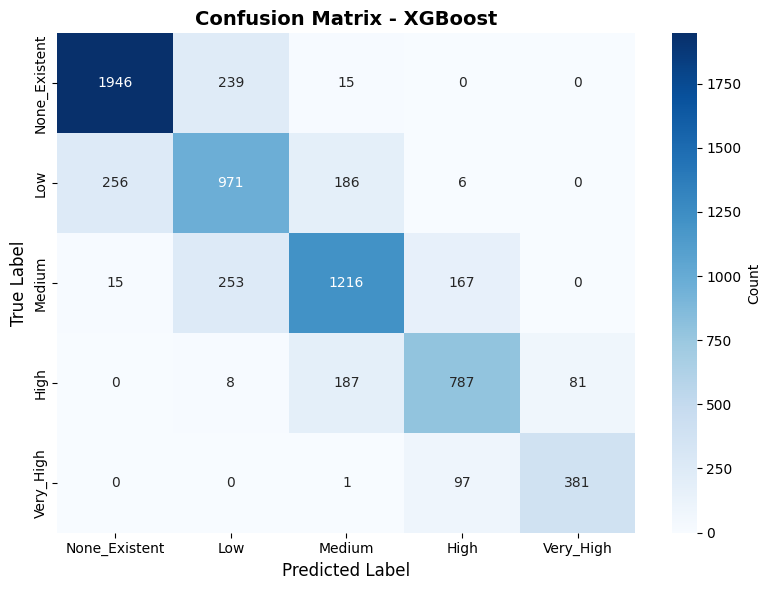

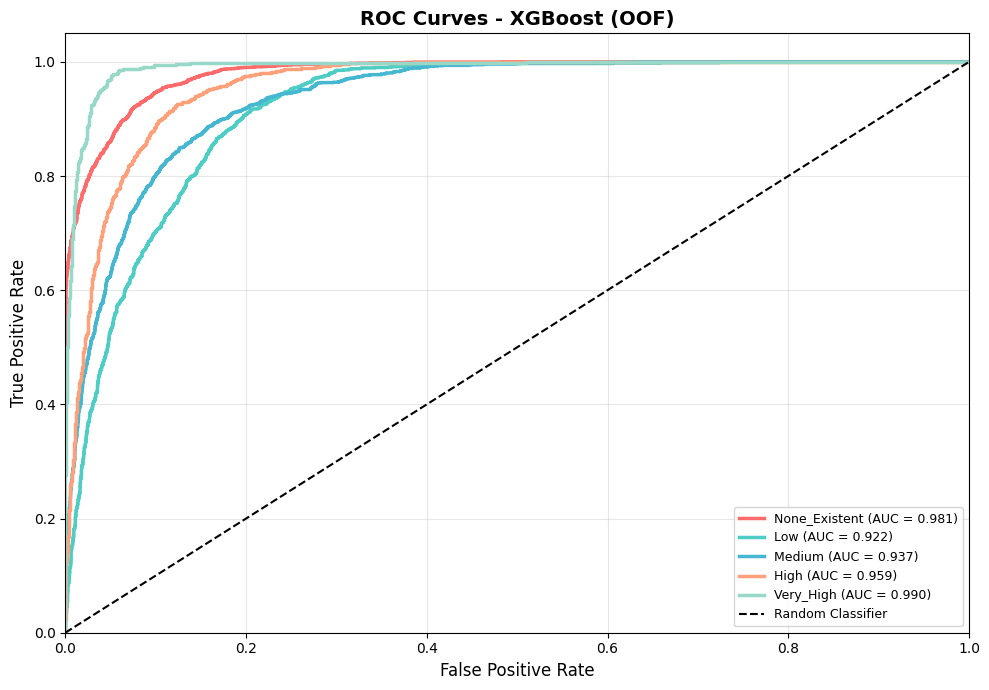

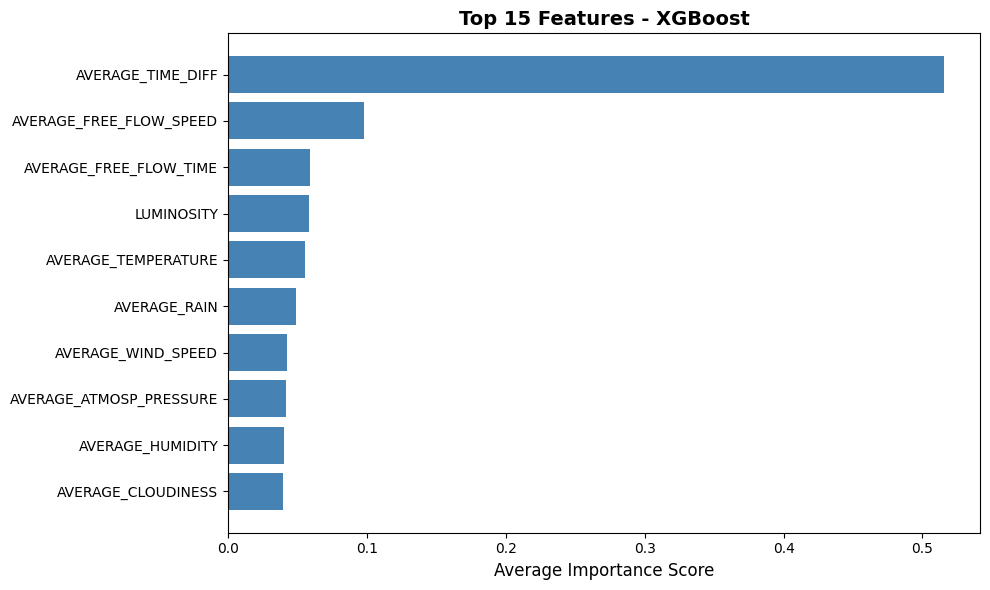


=============== RandomForest - OOF CV ===============
  Fold 1/5 - Accuracy: 0.8019
  Fold 2/5 - Accuracy: 0.7748
  Fold 3/5 - Accuracy: 0.7871
  Fold 4/5 - Accuracy: 0.7724
  Fold 5/5 - Accuracy: 0.7878

🎯 OOF Accuracy: 0.7848 ± 0.0106

📊 Classification Report (OOF):
               precision    recall  f1-score   support

None_Existent      0.880     0.899     0.889      2200
          Low      0.676     0.689     0.682      1419
       Medium      0.762     0.745     0.753      1651
         High      0.744     0.748     0.746      1063
    Very_High      0.839     0.764     0.800       479

     accuracy                          0.785      6812
    macro avg      0.780     0.769     0.774      6812
 weighted avg      0.785     0.785     0.785      6812



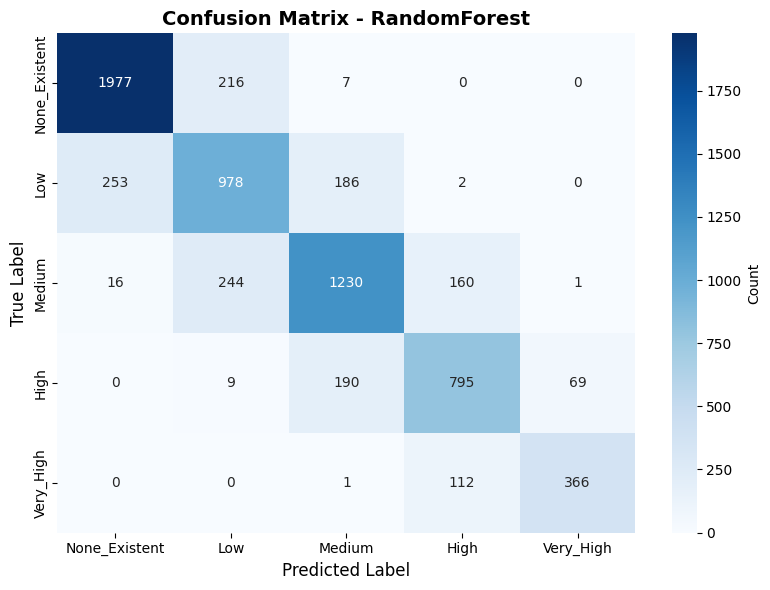

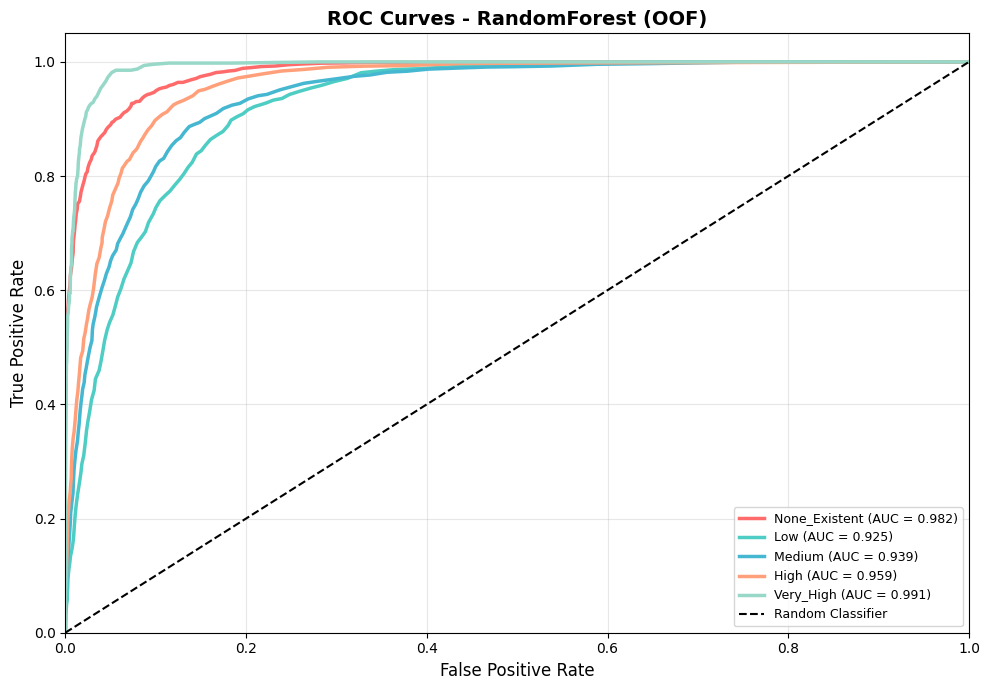

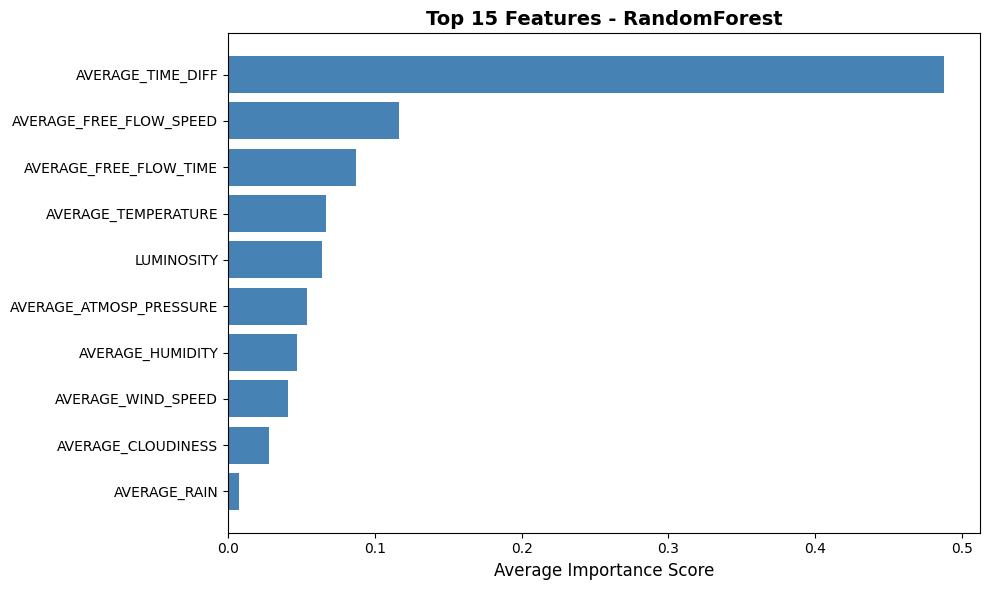


=============== LogisticRegression - OOF CV ===============


/home/toplapuser/.conda/envs/MECD/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/toplapuser/.conda/envs/MECD/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 2000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=2000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/toplapuser/.conda/envs/MECD/lib/python3.11/site-packages/sklearn/linear_mode

  Fold 1/5 - Accuracy: 0.7799


/home/toplapuser/.conda/envs/MECD/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 2000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=2000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/toplapuser/.conda/envs/MECD/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


  Fold 2/5 - Accuracy: 0.7535


/home/toplapuser/.conda/envs/MECD/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 2000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=2000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/toplapuser/.conda/envs/MECD/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


  Fold 3/5 - Accuracy: 0.7643


/home/toplapuser/.conda/envs/MECD/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 2000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=2000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/toplapuser/.conda/envs/MECD/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


  Fold 4/5 - Accuracy: 0.7438


/home/toplapuser/.conda/envs/MECD/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 2000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=2000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


  Fold 5/5 - Accuracy: 0.7761

🎯 OOF Accuracy: 0.7635 ± 0.0135

📊 Classification Report (OOF):
               precision    recall  f1-score   support

None_Existent      0.850     0.916     0.882      2200
          Low      0.663     0.619     0.640      1419
       Medium      0.729     0.752     0.740      1651
         High      0.736     0.680     0.707      1063
    Very_High      0.798     0.716     0.755       479

     accuracy                          0.764      6812
    macro avg      0.755     0.737     0.745      6812
 weighted avg      0.760     0.764     0.761      6812



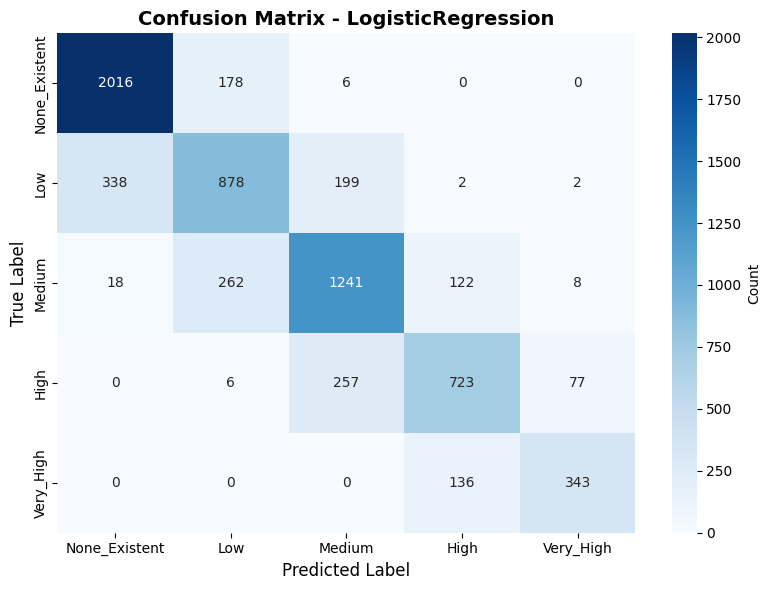

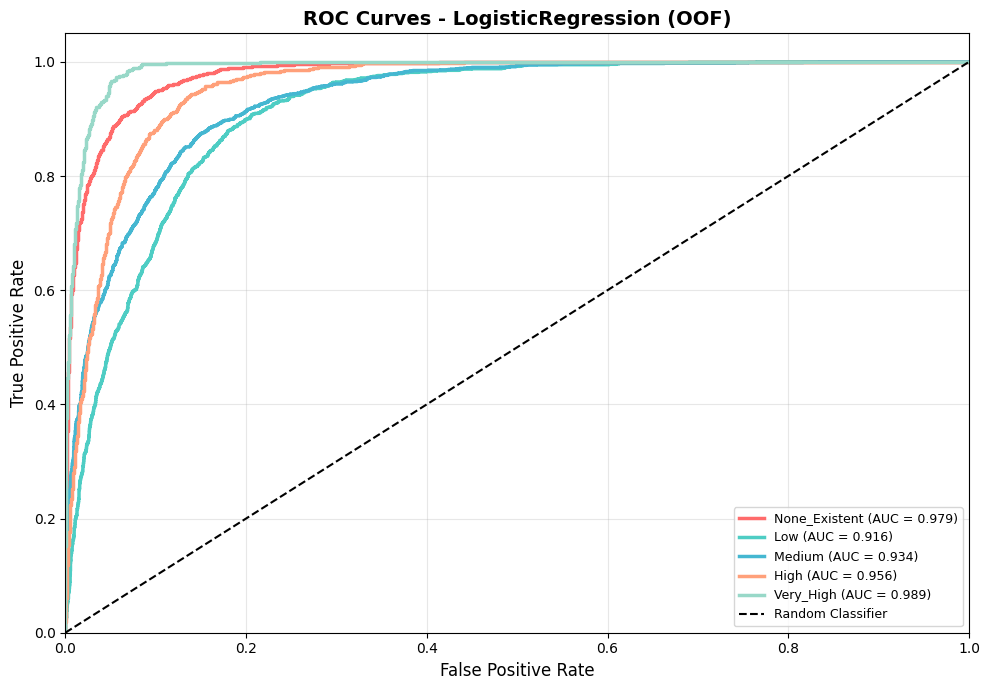


🏆 Best Model: RandomForest
🎯 OOF Accuracy: 0.7848

🔄 Creating ensemble predictions from RandomForest...

✅ Submission saved as "submission_oof.csv"
📈 Predicted distribution:
AVERAGE_SPEED_DIFF
None         485
Medium       342
Low          312
High         265
Very_High     96
Name: count, dtype: int64


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Models
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Metrics & Tools
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score
from sklearn.preprocessing import OrdinalEncoder, label_binarize

# ============== 1. LOAD DATA ==============
print("📂 Loading data...")
X_full = pd.read_csv('data/training_data_transformed.csv')
y_full = pd.read_csv('data/y_train_transformed.csv').values.ravel()
X_test_final = pd.read_csv('data/test_data_transformed.csv')

# ============== 2. PREPROCESSING ==============
# Drop non-numeric columns
for col in X_full.columns:
    if X_full[col].dtype == 'object':
        X_full = X_full.drop(columns=[col])
        X_test_final = X_test_final.drop(columns=[col])

# y_full is already numeric (0-4)
y_encoded = y_full.astype(int)

# Define label mapping
target_order = ['None_Existent', 'Low', 'Medium', 'High', 'Very_High']
oe = OrdinalEncoder(categories=[target_order])
oe.fit(np.array(target_order).reshape(-1, 1))

print(f"✅ Data loaded: {X_full.shape[0]} samples, {X_full.shape[1]} features")
print(f"✅ Target distribution:\n{pd.Series(y_encoded).value_counts().sort_index()}\n")

# ============== 3. MODEL DEFINITIONS ==============
def get_model(model_name):
    """Factory function to create fresh model instances"""
    models_dict = {
        'XGBoost': xgb.XGBClassifier(
            objective='multi:softprob',
            eval_metric='mlogloss',
            random_state=42,
            n_estimators=100
        ),
        'RandomForest': RandomForestClassifier(
            n_estimators=100,
            random_state=42,
            n_jobs=-1
        ),
        'LogisticRegression': LogisticRegression(
            max_iter=2000,
            random_state=42,
            multi_class='multinomial',
            n_jobs=-1
        )
    }
    return models_dict[model_name]

# ============== 4. OUT-OF-FOLD CROSS-VALIDATION ==============
def oof_cv_evaluation(X, y, model_name, n_splits=5):
    """
    Perform Out-of-Fold CV and return OOF predictions + trained models
    This gives a reliable generalization estimate without data leakage[4]
    """
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    oof_preds = np.zeros(len(y), dtype=int)
    oof_probs = np.zeros((len(y), len(target_order)))
    fold_scores = []
    trained_models = []
    
    print(f"\n{'='*15} {model_name} - OOF CV {'='*15}")
    
    for fold, (train_idx, val_idx) in enumerate(cv.split(X, y), 1):
        X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_val = y[train_idx], y[val_idx]
        
        # Create fresh model for each fold
        model = get_model(model_name)
        model.fit(X_tr, y_tr)
        
        # Store predictions
        oof_preds[val_idx] = model.predict(X_val)
        oof_probs[val_idx] = model.predict_proba(X_val)
        
        # Calculate fold score
        fold_acc = accuracy_score(y_val, oof_preds[val_idx])
        fold_scores.append(fold_acc)
        trained_models.append(model)
        
        print(f"  Fold {fold}/{n_splits} - Accuracy: {fold_acc:.4f}")
    
    # Overall OOF score
    oof_accuracy = accuracy_score(y, oof_preds)
    print(f"\n🎯 OOF Accuracy: {oof_accuracy:.4f} ± {np.std(fold_scores):.4f}")
    
    return oof_preds, oof_probs, trained_models, oof_accuracy

# ============== 5. VISUALIZATION FUNCTIONS ==============
def plot_confusion_matrix(y_true, y_pred, model_name, labels):
    """Plot confusion matrix heatmap"""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels,
                cbar_kws={'label': 'Count'})
    plt.title(f'Confusion Matrix - {model_name}', fontsize=14, fontweight='bold')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    plt.savefig(f'confusion_matrix_{model_name}.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_roc_curves(y_true, y_probs, model_name, labels):
    """Plot multi-class ROC curves using OOF probabilities"""
    n_classes = len(labels)
    y_true_bin = label_binarize(y_true, classes=range(n_classes))
    
    plt.figure(figsize=(10, 7))
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8']
    
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2.5, color=colors[i],
                label=f'{labels[i]} (AUC = {roc_auc:.3f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=1.5, label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(f'ROC Curves - {model_name} (OOF)', fontsize=14, fontweight='bold')
    plt.legend(loc="lower right", fontsize=9)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'roc_curve_{model_name}.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_feature_importance(models, feature_names, model_name, top_n=15):
    """Plot averaged feature importance across folds"""
    if not hasattr(models[0], 'feature_importances_'):
        return
    
    # Average importance across all folds
    avg_importance = np.mean([m.feature_importances_ for m in models], axis=0)
    indices = np.argsort(avg_importance)[-top_n:]
    
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(indices)), avg_importance[indices], color='steelblue')
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.xlabel('Average Importance Score', fontsize=12)
    plt.title(f'Top {top_n} Features - {model_name}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'feature_importance_{model_name}.png', dpi=300, bbox_inches='tight')
    plt.show()

# ============== 6. TRAIN & EVALUATE ALL MODELS ==============
model_names = ['XGBoost', 'RandomForest', 'LogisticRegression']
results = {}

for model_name in model_names:
    # OOF Cross-validation
    oof_preds, oof_probs, trained_models, oof_acc = oof_cv_evaluation(
        X_full, y_encoded, model_name, n_splits=5
    )
    
    # Store results
    results[model_name] = {
        'oof_preds': oof_preds,
        'oof_probs': oof_probs,
        'models': trained_models,
        'oof_accuracy': oof_acc
    }
    
    # Classification Report (on full OOF predictions)
    print(f"\n📊 Classification Report (OOF):")
    print(classification_report(y_encoded, oof_preds, target_names=target_order, digits=3))
    
    # Visualizations
    plot_confusion_matrix(y_encoded, oof_preds, model_name, target_order)
    plot_roc_curves(y_encoded, oof_probs, model_name, target_order)
    plot_feature_importance(trained_models, X_full.columns, model_name)

# ============== 7. SELECT BEST MODEL ==============
best_model_name = max(results, key=lambda x: results[x]['oof_accuracy'])
best_oof_acc = results[best_model_name]['oof_accuracy']

print(f"\n{'='*50}")
print(f"🏆 Best Model: {best_model_name}")
print(f"🎯 OOF Accuracy: {best_oof_acc:.4f}")
print(f"{'='*50}")

# ============== 8. FINAL SUBMISSION ==============
print(f"\n🔄 Creating ensemble predictions from {best_model_name}...")

# Average predictions from all 5 folds (more robust than single model)
best_models = results[best_model_name]['models']
test_probs = np.mean([model.predict_proba(X_test_final) for model in best_models], axis=0)
test_predictions = np.argmax(test_probs, axis=1)

# Decode predictions
test_labels = oe.inverse_transform(test_predictions.reshape(-1, 1)).ravel()

# Create submission
submission = pd.DataFrame({
    'RowId': np.arange(1, len(test_labels) + 1),
    'AVERAGE_SPEED_DIFF': pd.Series(test_labels).replace('None_Existent', 'None')
})

submission.to_csv('submission_oof.csv', index=False)
print('\n✅ Submission saved as "submission_oof.csv"')
print(f'📈 Predicted distribution:\n{submission["AVERAGE_SPEED_DIFF"].value_counts()}')
